In this file, I will be implemented a Neural Network to classify the crocodiles

In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler, LabelEncoder

import seaborn as sns

from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader, TensorDataset

import torch.optim as optim
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt


In [2]:
crocs_csv = pd.read_csv('crocodile_dataset.csv')
crocs_csv.head()

,Observation ID,Common Name,Scientific Name,Family,Genus,Observed Length (m),Observed Weight (kg),Age Class,Sex,Date of Observation,Country/Region,Habitat Type,Conservation Status,Observer Name,Notes
0,1,Morelet's Crocodile,Crocodylus moreletii,Crocodylidae,Crocodylus,1.90,62.0,Adult,Male,31-03-2018,Belize,Swamps,Least Concern,Allison Hill,Cause bill scientist nation opportunity.
1,2,American Crocodile,Crocodylus acutus,Crocodylidae,Crocodylus,4.09,334.5,Adult,Male,28-01-2015,Venezuela,Mangroves,Vulnerable,Brandon Hall,Ago current practice nation determine operatio...
2,3,Orinoco Crocodile,Crocodylus intermedius,Crocodylidae,Crocodylus,1.08,118.2,Juvenile,Unknown,07-12-2010,Venezuela,Flooded Savannas,Critically Endangered,Melissa Peterson,Democratic shake bill here grow gas enough ana...
3,4,Morelet's Crocodile,Crocodylus moreletii,Crocodylidae,Crocodylus,2.42,90.4,Adult,Male,01-11-2019,Mexico,Rivers,Least Concern,Edward Fuller,Officer relate animal direction eye bag do.
4,5,Mugger Crocodile (Marsh Crocodile),Crocodylus palustris,Crocodylidae,Crocodylus,3.75,269.4,Adult,Unknown,15-07-2019,India,Rivers,Vulnerable,Donald Reid,Class great prove reduce raise author play mov...


In [3]:
def make_heatmap(crocs):
    df = crocs.copy()
    #Using label encoder to make a heatmap of correlations
    age_map = {"Hatchling": 0, "Juvenile": 1, "Subadult": 2, "Adult": 3}
    df['Age Class'] = df['Age Class'].map(age_map).fillna(-1).astype(int)

    cols_to_encode = ['Sex', 'Habitat Type', 'Country/Region']
    for col in cols_to_encode:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
    
    sns.set_theme(font_scale=1)
    sns.heatmap(df.corr(), cbar=True, annot=True, square=True, fmt='.2f',
                      annot_kws={'size': 12}, yticklabels=df.columns, xticklabels=df.columns)

#### Preprocessing the Data

In [4]:
#Preprocessing the data in a method we can can call it from main
def preprocessing_data(crocs):
    # Removing unnecessary columns
    crocs = crocs.drop(['Observation ID', 'Scientific Name', 'Family', 'Genus', 'Conservation Status', 'Observer Name', 'Notes'], axis=1)
    
    # Dropping the Borneo Crocodile since its disputed
    indices_to_drop = crocs[crocs['Common Name'] == 'Borneo Crocodile (disputed)'].index
    crocs.drop(indices_to_drop, inplace=True)

    #Converting the data into two features, one for the month and another for the year
    crocs['Date of Observation'] = pd.to_datetime(crocs['Date of Observation'])

    #Getting month and year stats
    crocs['Year'] = crocs['Date of Observation'].dt.year
    crocs['Month'] = crocs['Date of Observation'].dt.month

    crocs = crocs.drop(columns=['Date of Observation'], axis=1)

    #Normalizing the year
    max_year = crocs.max(axis=0)['Year']
    min_year = crocs.min(axis=0)['Year']
    crocs['Year'] = (crocs['Year'] - min_year) / (max_year - min_year)

    #Normalizing the month
    crocs['Month'] = np.sin((np.pi*crocs['Month']) / 12)

    #Normalizing length and weight
    scaler = StandardScaler()
    scale = ['Observed Length (m)', 'Observed Weight (kg)']
    crocs[scale] = scaler.fit_transform(crocs[scale])

    #Converting the name to integers
    le = LabelEncoder()
    crocs['Common Name'] = le.fit_transform(crocs['Common Name'])

    make_heatmap(crocs)

    #One hot encoding the remaining features
    crocs = pd.get_dummies(crocs, columns=['Age Class', 'Sex', 'Habitat Type', 'Country/Region'], drop_first=True)

    # Creating the target and removing it from the croc dataframe
    target = crocs['Common Name']
    crocs.drop(['Common Name'], axis=1, inplace=True)

    #Returning the new dataframe and the target
    return crocs, target

#### Creating the Train Test split and preparing the data

In [5]:
def create_dataloaders(crocs, target, random_state, batchsize):
    X_train, X_test, y_train, y_test = train_test_split(crocs, target, test_size=0.2, random_state=random_state, stratify=target)

    X_train = torch.tensor(X_train.astype(float).values, dtype=torch.float32)
    X_test = torch.tensor(X_test.astype(float).values, dtype=torch.float32)
    y_train = torch.tensor(y_train.astype(float).values, dtype=torch.long)
    y_test = torch.tensor(y_test.astype(float).values, dtype=torch.long)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

    return train_loader, test_loader

#### Creating a Neural Network

In [6]:
import torch.nn as nn
class ModelV1(nn.Module):
    def __init__(self, input_size, hidden, output_size):
        super().__init__()
        self.in_layer = nn.Linear(in_features=input_size, out_features=hidden)
        self.hidden = nn.Linear(in_features=hidden, out_features=hidden)
        self.out_layer = nn.Linear(in_features=hidden, out_features=output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.in_layer(x))
        x = self.relu(self.hidden(x))
        x = self.relu(self.hidden(x))
        x = self.out_layer(x)
        return x

In [7]:
#Creating an accuracy function
def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [8]:
def plot_graphs(train_losses, test_losses):
    plt.figure(figsize=(8, 6))
    plt.subplot(1,2,1)
    plt.plot(train_losses, label="Train Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title('Training Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(test_losses, label="Validation Loss")
    plt.title("Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

In [9]:
def training_loop(train_loader, test_loader, crocs, target, num_epochs, loss_fn, optimizer, model):
    num_classes = target.max(axis=0) + 1
    print(f"There are {len(crocs.columns)} input variables and {num_classes} output classes")

    epochs = num_epochs
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        for X, y in train_loader:
            optimizer.zero_grad()
            preds = model(X)

            #Calculate loss and accuracy
            loss = loss_fn(preds, y)
            train_loss += loss.item()
            pred_classes = torch.argmax(torch.softmax(preds, dim=1), dim=1)
            train_acc += (pred_classes == y).sum().item() / len(preds)

            loss.backward()
            optimizer.step()
        train_acc /= len(train_loader)
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        #Validation Loop
        model.eval()
        test_loss = 0
        test_acc = 0
        with torch.inference_mode():
            for X, y in test_loader:
                preds = model(X)
                loss = loss_fn(preds, y)
                test_loss += loss.item()
                pred_classes = torch.argmax(torch.softmax(preds, dim=1), dim=1)
                test_acc += (pred_classes == y).sum().item() / len(preds)
        test_acc /= len(test_loader)
        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
        if epoch % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} |  Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")    

    plot_graphs(train_losses, test_losses)

    return model

In [10]:
def generate_confusion_matrix(y_true, y_pred, crocs_csv):
    le = LabelEncoder()
    crocs_csv['Common Name'] = le.fit_transform(crocs_csv['Common Name'])
    output_classes = le.classes_

    #Generating a confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=output_classes, 
                yticklabels=output_classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()


#### Creating the Training Loop

In [11]:
def testing(model, loss_fn, test_loader, crocs_csv):
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    all_preds = []   # for AUC
    all_labels = []  # true labels

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch, y_batch

            outputs = model(X_batch) # Logits
            loss = loss_fn(outputs, y_batch)

            test_loss += loss.item() * X_batch.size(0)

            probs = torch.softmax(outputs, dim=1)

            # Store for AUC
            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

            # Accuracy (thresholded at 0.5)
            preds = probs.argmax(dim=1)
            test_correct += (preds == y_batch).sum().item()
            test_total += y_batch.size(0)
    #Generating a confusion matrix
    generate_confusion_matrix(all_labels, np.argmax(all_preds, axis=1), crocs_csv)

    # Compute averages
    avg_test_loss = test_loss / test_total
    acc_nn = test_correct / test_total

    # Compute AUC
    auc_nn = roc_auc_score(all_labels, all_preds, multi_class='ovr')

    print(f"\nTest Loss: {avg_test_loss:.4f}")
    print(f"Test Accuracy: {acc_nn:.4f}")
    print(f"Test AUC: {auc_nn:.4f}")

In [12]:
#Learning about the dataset
column_name = 'Common Name'
types_of_croc = []
for croc_type in crocs_csv[column_name].unique(): #Getting the names of every crocodile
    types_of_croc.append(croc_type)

print(f"There are {len(types_of_croc)} types of crocodiles in the dataset:")
total = 0
for croc in types_of_croc:
    mask = crocs_csv[column_name] == croc
    count = len(crocs_csv[mask])
    total += count
    print(f"There are {count} observations of {croc} which is {count/len(crocs_csv) * 100:.2f}% of the dataset")
print("The average percent is ", total/len(types_of_croc) / len(crocs_csv) * 100)

There are 18 types of crocodiles in the dataset:
There are 64 observations of Morelet's Crocodile which is 6.40% of the dataset
There are 66 observations of American Crocodile which is 6.60% of the dataset
There are 58 observations of Orinoco Crocodile which is 5.80% of the dataset
There are 47 observations of Mugger Crocodile (Marsh Crocodile) which is 4.70% of the dataset
There are 45 observations of Siamese Crocodile which is 4.50% of the dataset
There are 48 observations of Congo Dwarf Crocodile which is 4.80% of the dataset
There are 52 observations of West African Crocodile which is 5.20% of the dataset
There are 57 observations of West African Dwarf Crocodile which is 5.70% of the dataset
There are 48 observations of Nile Crocodile which is 4.80% of the dataset
There are 67 observations of Borneo Crocodile (disputed) which is 6.70% of the dataset
There are 58 observations of Saltwater Crocodile which is 5.80% of the dataset
There are 59 observations of Cuban Crocodile which is 5

C:\Users\jonny\AppData\Local\Temp\ipykernel_19404\377865104.py:11: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  crocs['Date of Observation'] = pd.to_datetime(crocs['Date of Observation'])


,Observed Length (m),Observed Weight (kg),Year,Month,Age Class_Hatchling,Age Class_Juvenile,Age Class_Subadult,Sex_Male,Sex_Unknown,Habitat Type_Brackish Rivers,...,Country/Region_Sierra Leone,Country/Region_South Africa,Country/Region_Sri Lanka,Country/Region_Sudan,Country/Region_Tanzania,Country/Region_Thailand,Country/Region_USA (Florida),Country/Region_Uganda,Country/Region_Venezuela,Country/Region_Vietnam
0,-0.454967,-0.535355,0.65,7.071068e-01,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1.507375,0.976625,0.50,2.588190e-01,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
2,-1.189725,-0.223526,0.25,1.224647e-16,False,True,False,False,True,False,...,False,False,False,False,False,False,False,False,True,False
3,0.010977,-0.377776,0.70,2.588190e-01,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1.202720,0.615414,0.70,9.659258e-01,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


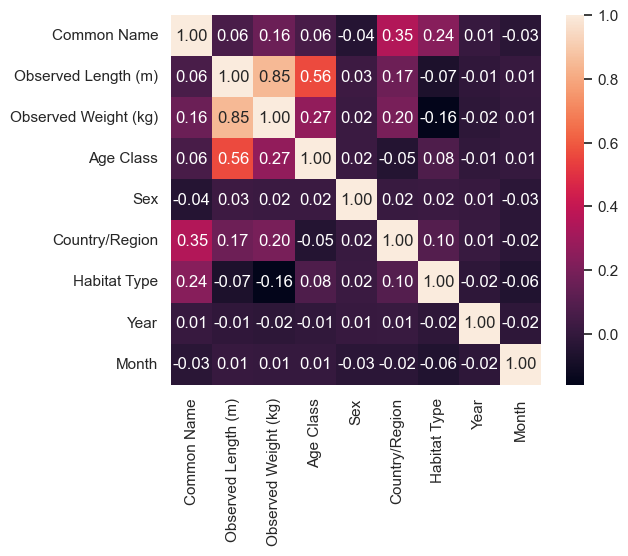

In [13]:
# Running the whole thing:
crocs, target = preprocessing_data(crocs_csv)
crocs.head()

There are 80 input variables and 17 output classes
Epoch [1/81] | Train Loss: 2.8479 | Test Loss: 2.8427 |  Train Acc: 0.0593 | Test Acc: 0.0595
Epoch [11/81] | Train Loss: 2.5071 | Test Loss: 2.4547 |  Train Acc: 0.3025 | Test Acc: 0.3322
Epoch [21/81] | Train Loss: 1.0243 | Test Loss: 0.9703 |  Train Acc: 0.8246 | Test Acc: 0.8133
Epoch [31/81] | Train Loss: 0.3066 | Test Loss: 0.3039 |  Train Acc: 0.9537 | Test Acc: 0.9618
Epoch [41/81] | Train Loss: 0.1172 | Test Loss: 0.1205 |  Train Acc: 0.9713 | Test Acc: 0.9731
Epoch [51/81] | Train Loss: 0.0658 | Test Loss: 0.0718 |  Train Acc: 0.9772 | Test Acc: 0.9787
Epoch [61/81] | Train Loss: 0.0481 | Test Loss: 0.0504 |  Train Acc: 0.9844 | Test Acc: 0.9787
Epoch [71/81] | Train Loss: 0.0382 | Test Loss: 0.0404 |  Train Acc: 0.9883 | Test Acc: 0.9839
Epoch [81/81] | Train Loss: 0.0356 | Test Loss: 0.0401 |  Train Acc: 0.9831 | Test Acc: 0.9839


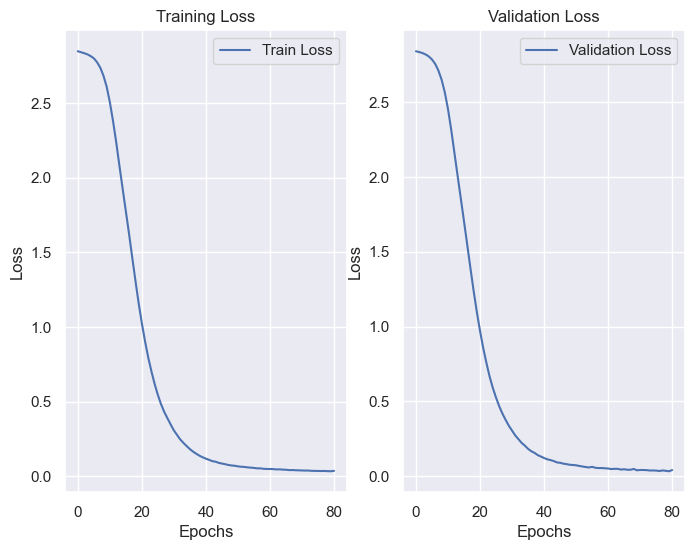

In [14]:
train_loader, test_loader = create_dataloaders(crocs, target, 42, 64)
loss_fn = nn.CrossEntropyLoss()
num_classes = target.max(axis=0) + 1
model = ModelV1(input_size=len(crocs.columns), hidden=16, output_size=num_classes)
optimizer = optim.Adam(params=model.parameters(), lr=0.001)
model = training_loop(train_loader, test_loader, crocs, target, 81, loss_fn, optimizer, model)

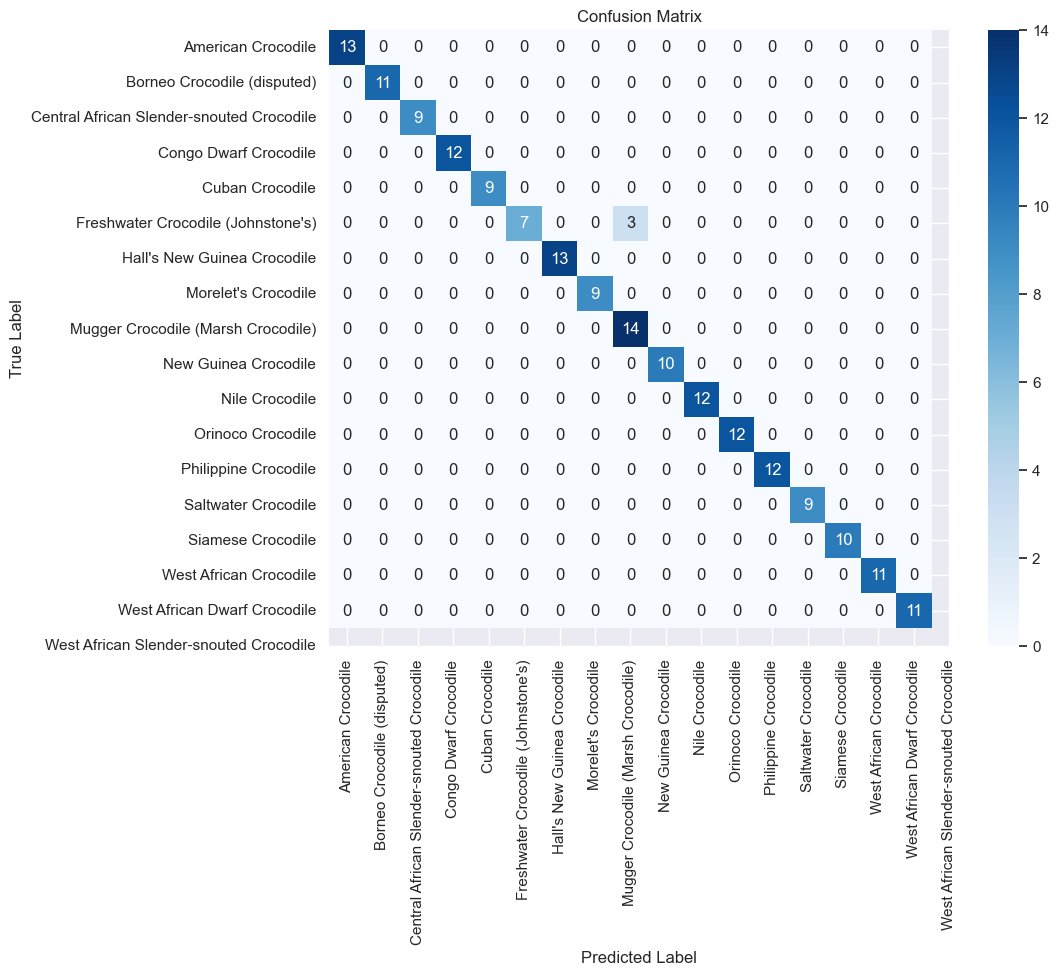


Test Loss: 0.0400
Test Accuracy: 0.9840
Test AUC: 1.0000


In [15]:
testing(model, loss_fn, test_loader, crocs_csv)